## Meta Learners

### Concepts


#### S-Learner
- S stands for 'Single'
  - estimate treatment effect using a single machine learning model
- Expression:
  - $\hat{\tau}(x)=E[Y(1)-Y(0)|X=x]$
- Put control group and experiment group into the **same** model **at the same time**.
- Evaluation:
  - Simple to implement, be good at dealing with difference biases
  - cannot handle datasets with <u>high dimensional features, imbalanced dataset, and selection bias</u>.

#### T-Learner
- T stands for 'Two'
  - estimate control group and experiment group with two difference machine learning models **separately**
- Expression:
  - $\hat{\mu_0(x)}=E[Y(0)|X=x]$
  - $\hat{\mu_1(x)}=E[Y(1)|X=x]$
  - $\hat{\tau}(x)=\hat{\mu_1(x)}-\hat{\mu_0(x)}$
- Restriction: treatments have to be <u>discrete variables</u>.
- Evaluation:
  - Two machine learning models cannot learn dataset of each other, contributing to *huge error* when make predictions.
    - With learning less dataset, the model performance is more likely to be influenced by some noise.

#### X-Learner
- X describes the shape of the training set
- Procedures:
  - estimate response effect with supervised or regression models with traditional machine learning models:
    - $\hat{\mu_0(x)}=E[Y(0)|X=x]$
    - $\hat{\mu_1(x)}=E[Y(1)|X=x]$
  - impute treatment effects for both treatment and control groups by gaining difference between true effect and estimated effect:
    - $\hat{D_i ^1}=Y_i ^1-\hat{\mu_0(X_i ^1)}$
    - $\hat{D_i ^0}=\hat{\mu_0(X_i ^0)}-Y_i ^0$
  - CATE estimator with traditional machine learning models:
    - $\hat{\tau}(x)=g(x)\hat{\tau_0}(x)+(1-g(x))\hat{\tau_1}(x)$
      - $\hat{\tau_0}(x)=E[\hat{D_i ^0}|X=x]$
      - $\hat{\tau_1}(x)=E[\hat{D_i ^1}|X=x]$
      - $g(x)\in [0,1]$:weights function, in order to minimize the high variance of $\hat{\tau}$
        - sometimes, we use propensity score $e(x)$ to get $g(x)$.
- Evaluation:
  - make efficient use of an unbalanced data, make full use of dataset to extract information
  - correct the wrong CATE predictions at non-linearity

#### R-Learner

### Evaluation Methods

##### Qini Curve & AUUC


## Case Study (Toys)

In [1]:
!pip install fklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.4
    Not uninstalling numpy at /shared-libs/python3.9/py/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Not uninstalling joblib at /shared-libs/python3.9/py/lib/python3.9/site-packages, outside environ

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fklearn.causal.validation.curves import relative_cumulative_gain_curve
from fklearn.causal.validation.auc import area_under_the_relative_cumulative_gain_curve

### Meta-Learners with Discrete Treatments

- Background:
  - We want to know which customers are sensitive to the marketing email, estimating the conditional average treatment effect of an email on customers' future purchase amount.
- Datasets:
  - customer behavior historical data, huge amount
  - randomized, tiny amount

In [3]:
#import datasets
data_biased=pd.read_csv('/work/email_obs_data.csv')
data_random=pd.read_csv('/work/email_rnd_data.csv')

In [4]:
data_biased.head()

,mkt_email,next_mnth_pv,age,tenure,ammount_spent,vehicle,food,beverage,art,baby,...,electronics,sports,tools,games,industry,pc,jewel,books,music_books_movies,health
0,0,34.38,32.0,0.0,18.05,0,0,1,1,1,...,3,0,1,0,1,2,2,0,1,1
1,0,183.14,23.0,1.0,182.97,0,0,0,1,0,...,1,1,0,0,0,2,2,1,2,1
2,0,54.26,29.0,0.0,29.57,0,0,0,1,4,...,3,0,0,0,3,0,0,0,1,4
3,1,1409.71,44.0,0.0,142.15,1,2,0,1,0,...,1,0,1,1,1,3,0,1,0,5
4,0,120.16,30.0,0.0,132.11,0,1,1,0,1,...,1,2,1,1,2,3,0,0,2,5


In [5]:
data_random.head()

,mkt_email,next_mnth_pv,age,tenure,ammount_spent,vehicle,food,beverage,art,baby,...,electronics,sports,tools,games,industry,pc,jewel,books,music_books_movies,health
0,0,244.26,61.0,1.0,21.84,0,2,2,0,2,...,1,0,0,3,1,0,1,0,0,2
1,0,29.67,36.0,1.0,107.40,0,2,0,2,0,...,1,1,1,2,1,2,1,0,2,2
2,0,11.73,64.0,0.0,59.81,0,1,0,0,0,...,2,0,0,3,0,1,0,1,0,1
3,0,41.41,74.0,0.0,62.98,0,1,0,0,3,...,1,0,2,2,1,1,0,4,1,0
4,0,447.89,59.0,0.0,72.56,0,1,1,3,2,...,5,0,0,1,0,0,1,1,2,1


In [6]:
#查看数据量
print(len(data_biased), len(data_random))

300000 10000


- Treatment Variables: `mkt_email`
- Outcome Variables: `next_mnth_pv`
- Confounders: other variables, making treatment heterogeneity

In [7]:
# state the variables
Y='next_mnth_pv'
T='mkt_email'
X=list(data_random.drop(columns=[Y,T]).columns)
train, test = data_biased, data_random

- T-Learner Training with LightGBM

In [9]:
!pip install lightgbm 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [10]:
from lightgbm import LGBMRegressor

In [11]:
np.random.seed(123)

In [34]:
model0=LGBMRegressor()
model1=LGBMRegressor()

In [35]:
model0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[Y])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 146759, number of used features: 25
[LightGBM] [Info] Start training from score 88.249324


LGBMRegressor()

In [36]:
model1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[Y])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 153241, number of used features: 25
[LightGBM] [Info] Start training from score 1596.224063


LGBMRegressor()

In [37]:
#using test dataset to predict CATE
t_learner_cate_pred=test.assign(cate=model1.predict(test[X])-model0.predict(test[X]))

Text(0.5, 1.0, 'T-Learner Performance')

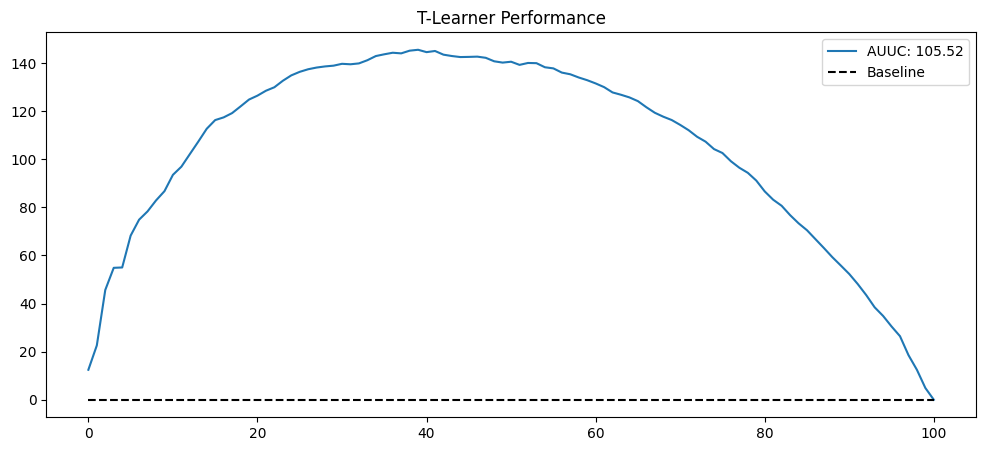

In [40]:
#model evaluation
gain_curve_test = relative_cumulative_gain_curve(t_learner_cate_pred, T, Y, prediction="cate")
auuc = area_under_the_relative_cumulative_gain_curve(t_learner_cate_pred, T, Y, prediction="cate")

plt.figure(figsize=(12,5))
plt.plot(gain_curve_test, color="C0", label=f"AUUC: {auuc:.2f}")
plt.hlines(0, 0, 100, linestyle="--", color="black", label="Baseline")

plt.legend()
plt.title("T-Learner Performance")

- X-Learner Training

In [19]:
from sklearn.linear_model import LogisticRegression

In [41]:
#get the g(x) weight value
ps_model = LogisticRegression(penalty='none')
ps_model.fit(train[X], train[T])
#first stage
train_t0 = train.query(f"{T}==0")
train_t1 = train.query(f"{T}==1")
model0 = LGBMRegressor()
model1 = LGBMRegressor()
model0.fit(train_t0[X], 
           train_t0[Y],
           sample_weight=1/ps_model.predict_proba(train_t0[X])[:, 0])

model1.fit(train_t1[X], 
           train_t1[Y],
           sample_weight=1/ps_model.predict_proba(train_t1[X])[:, 1])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 146759, number of used features: 25
[LightGBM] [Info] Start training from score 93.788164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 153241, number of used features: 25
[LightGBM] [Info] Start training from score 1500.814889


LGBMRegressor()

In [42]:
#second step:calculate the differences between predicted value and true value
hat_tau_0=model1.predict(train_t0[X]) - train_t0[Y]
hat_tau_1=train_t1[Y]-model0.predict(train_t1[X])

tau_0_model=LGBMRegressor()
tau_1_model=LGBMRegressor()

tau_0_model.fit(train_t0[X], hat_tau_0)
tau_1_model.fit(train_t1[X], hat_tau_1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 146759, number of used features: 25
[LightGBM] [Info] Start training from score 1314.591612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 153241, number of used features: 25
[LightGBM] [Info] Start training from score 1496.430568


LGBMRegressor()

In [43]:
#estimate CATE
ps_test = ps_model.predict_proba(test[X])[:, 1] #get the weight
x_cate_test = test.assign(
            cate=(ps_test*tau_0_model.predict(test[X])+(1-ps_test)*tau_1_model.predict(test[X]))
        )
        

Text(0.5, 1.0, 'X-Learner')

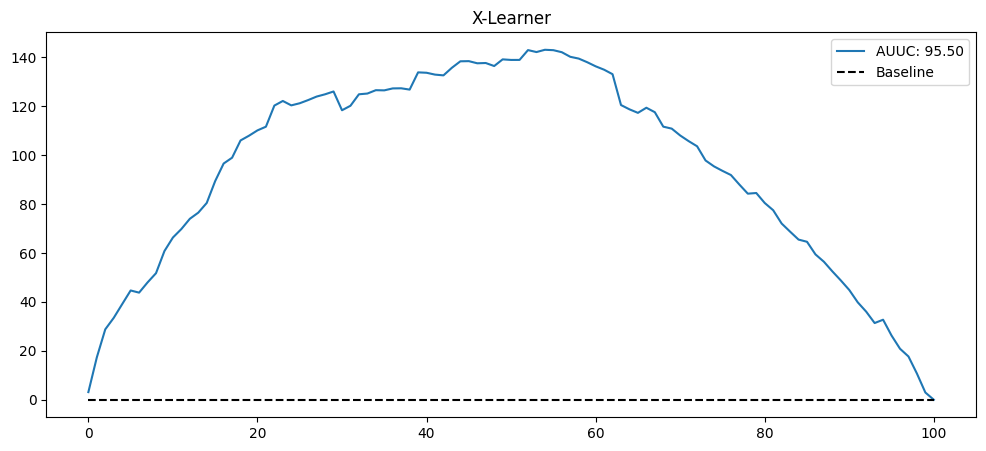

In [44]:
gain_curve_test = relative_cumulative_gain_curve(x_cate_test, T, Y, prediction="cate")
auuc = area_under_the_relative_cumulative_gain_curve(x_cate_test, T, Y, prediction="cate")

plt.figure(figsize=(12, 5))
plt.plot(gain_curve_test, color="C0", label=f"AUUC: {auuc:.2f}")
plt.hlines(0, 0, 100, linestyle="--", color="black", label="Baseline")

plt.legend()
plt.title("X-Learner")

### Metalearners for Continuous Treatments

- Background:
  - 3 year's discounts and sales data from chained restaurants
  - We wonder when is the best timing to give more discounts in the unit of day
    - Namely, on **which days customers are more sensitive to prices/discounts** is the topic we are interested.

In [46]:
data_ctu=pd.read_csv('/work/discount_data.csv')
data_ctu.head()

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,False,True,False,False,2.88,0,79.0
1,0,2016-01-02,1,5,True,False,False,False,2.64,0,57.0
2,0,2016-01-03,1,6,True,False,False,False,2.08,5,294.0
3,0,2016-01-04,1,0,False,False,False,False,3.37,15,676.5
4,0,2016-01-05,1,1,False,False,False,False,3.79,0,66.0


In [47]:
train = data_ctu.query("day<'2018-01-01'")
test = data_ctu.query("day>='2018-01-01'")

In [48]:
X = ["month", "weekday", "is_holiday", "competitors_price"]
T = "discounts"
Y = "sales"
s_learner = LGBMRegressor()
s_learner.fit(train[X+[T]], train[Y]) #we train control and treated group simutanously

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 5117, number of used features: 5
[LightGBM] [Info] Start training from score 375.131425


In [49]:
#define the grid of treatments
t_grid = pd.DataFrame(dict(key=1, discounts=np.array([0, 10, 20, 30, 40]))) #create the dataframe
#only giving a change on discounts column
test_cf = (test.drop(columns=["discounts"]).assign(key=1)
           .merge(t_grid)
           .assign(sales_hat = lambda d: s_learner.predict(d[X+[T]]))) #use test dataset to make sales prediction
test_cf.head()

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,sales,key,discounts,sales_hat
0,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,0,67.957972
1,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,10,444.245941
2,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,20,793.045769
3,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,30,1279.640793
4,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,40,1512.630767


<AxesSubplot: xlabel='discounts', ylabel='sales_hat'>

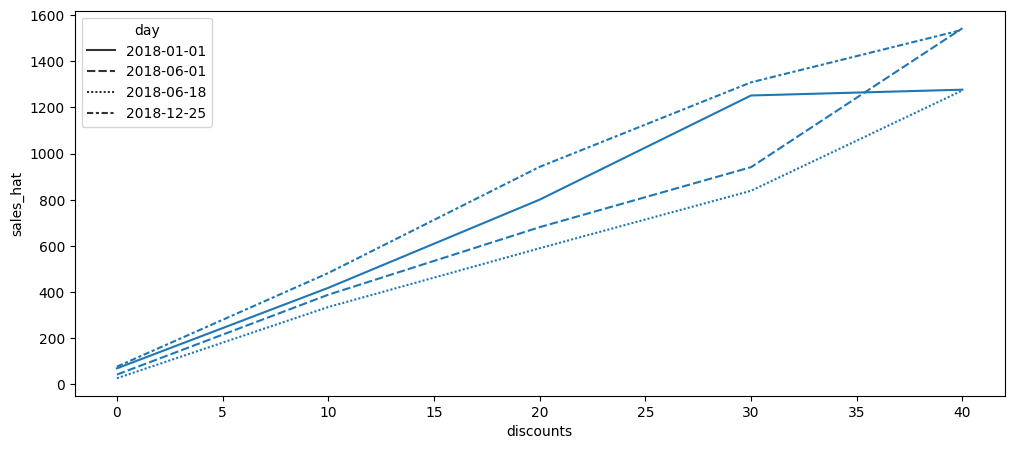

In [53]:
#visualization
days = ["2018-12-25", "2018-01-01", "2018-06-01", "2018-06-18"]

plt.figure(figsize=(12, 5))
sns.lineplot(data=test_cf.query("day.isin(@days)").query("rest_id==1"), #we can try from 0~5 restaurant
             y="sales_hat",
             x="discounts",
             style="day")

- in Christmas, the slop is higher than others in total
  - Customers are more price-sensitive at Christmas

In [54]:
from toolz import curry
#get the `slope` with linear regression formula, aimed to get CATE estimation

@curry
def linear_effect(df, y, t):
    return np.cov(df[y], df[t])[0, 1]/df[t].var()

cate = (test_cf.groupby(["rest_id", "day"]).apply(linear_effect(t="discounts", y="sales_hat")).rename("cate"))

test_s_learner_pred = test.set_index(["rest_id", "day"]).join(cate)
test_s_learner_pred.head()

month  weekday  weekend  is_holiday  is_dec  is_nov  \
rest_id day                                                               
0       2018-01-01      1        0    False        True   False   False   
        2018-01-02      1        1    False       False   False   False   
        2018-01-03      1        2    False       False   False   False   
        2018-01-04      1        3    False       False   False   False   
        2018-01-05      1        4    False       False   False   False   

                    competitors_price  discounts  sales       cate  
rest_id day                                                         
0       2018-01-01               4.92          5  251.5  37.247404  
        2018-01-02               3.06         10  541.0  40.269854  
        2018-01-03               4.61         10  431.0  37.412988  
        2018-01-04               4.84         20  760.0  38.436815  
        2018-01-05               6.29          0   78.0  31.428603

Text(0.5, 1.0, 'S-Learner')

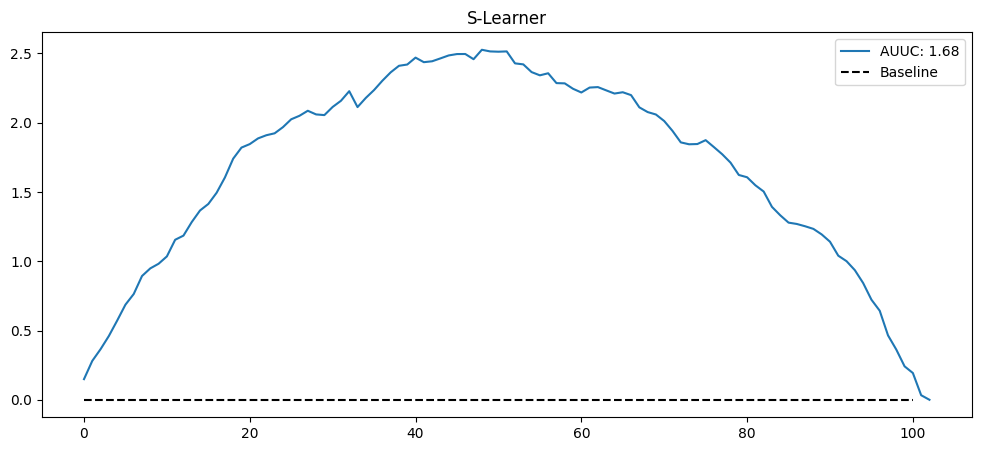

In [55]:
gain_curve_test = relative_cumulative_gain_curve(test_s_learner_pred, T, Y, prediction="cate")
auuc = area_under_the_relative_cumulative_gain_curve(test_s_learner_pred, T, Y, prediction="cate")

plt.figure(figsize=(12, 5))
plt.plot(gain_curve_test, color="C0", label=f"AUUC: {auuc:.2f}")
plt.hlines(0, 0, 100, linestyle="--", color="black", label="Baseline")

plt.legend()
plt.title("S-Learner")

### Metalearners with CausalML & DragonNet

### References
- Causal Inference for Brave and True. https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html
- CausalML. https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html
- EconML.
  - https://econml.azurewebsites.net/spec/estimation/metalearners.html
  - https://nbviewer.org/github/py-why/EconML/blob/main/notebooks/Metalearners%20Examples.ipynb
- Meta-learners for Estimating Treatment Effect in Causal Inference. https://towardsdatascience.com/meta-learners-for-estimating-treatment-effect-in-causal-inference-4f7071503401

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f9e7f60c-c48e-4bd1-91c3-dd4a71a2aa40' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>